<a href="https://colab.research.google.com/github/Erfan-the-analyst/Erfan-the-analyst/blob/main/Sentiment_Analysis_(new_pipeline).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
# Step1. import necessary packages
import pandas as pd # dataframe
import re #regex --> regular expression --> \w\@\w\.\w
import nltk #natural language toolkit
from nltk.corpus import stopwords #corpus=text document collection
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
!wget --no-check-certificate https://jmcauley.ucsd.edu/data/amazon_v2/categoryFilesSmall/AMAZON_FASHION_5.json.gz

In [24]:
# Step 2: Load the data
import json
import gzip
### load the meta data
data = []
with gzip.open('AMAZON_FASHION_5.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))

In [25]:
df = pd.DataFrame(data)

In [26]:
df.shape

(3176, 12)

In [ ]:
df.sample(5)

In [29]:
df.head(5)

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5.0,True,"09 4, 2015",ALJ66O1Y6SLHA,B000K2PJ4K,"{'Size:': ' Big Boys', 'Color:': ' Blue/Orange'}",Tonya B.,Great product and price!,Five Stars,1441324800,NaN,NaN
1,5.0,True,"09 4, 2015",ALJ66O1Y6SLHA,B000K2PJ4K,"{'Size:': ' Big Boys', 'Color:': ' Black (3746...",Tonya B.,Great product and price!,Five Stars,1441324800,NaN,NaN
2,5.0,True,"09 4, 2015",ALJ66O1Y6SLHA,B000K2PJ4K,"{'Size:': ' Big Boys', 'Color:': ' Blue/Gray L...",Tonya B.,Great product and price!,Five Stars,1441324800,NaN,NaN
3,5.0,True,"09 4, 2015",ALJ66O1Y6SLHA,B000K2PJ4K,"{'Size:': ' Big Boys', 'Color:': ' Blue (37867...",Tonya B.,Great product and price!,Five Stars,1441324800,NaN,NaN
4,5.0,True,"09 4, 2015",ALJ66O1Y6SLHA,B000K2PJ4K,"{'Size:': ' Big Boys', 'Color:': ' Blue/Pink'}",Tonya B.,Great product and price!,Five Stars,1441324800,NaN,NaN


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3176 entries, 0 to 3175
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   overall         3176 non-null   float64
 1   verified        3176 non-null   bool   
 2   reviewTime      3176 non-null   object 
 3   reviewerID      3176 non-null   object 
 4   asin            3176 non-null   object 
 5   style           3107 non-null   object 
 6   reviewerName    3176 non-null   object 
 7   reviewText      3160 non-null   object 
 8   summary         3176 non-null   object 
 9   unixReviewTime  3176 non-null   int64  
 10  vote            297 non-null    object 
 11  image           106 non-null    object 
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 276.2+ KB


In [31]:
reviews = df['reviewText']
label = df['overall']

In [32]:
reviews.isnull().sum()

16

In [33]:
#Null value handling
reviews = reviews.fillna('neutral') #arbitrary value

In [34]:
reviews.isnull().sum()

0

In [35]:
def text_preprocessing(text):
  #lowercase
  text = text.lower()
  #remove punctuation
  text = re.sub(r'[^\w\s]', '', text) #not words not space
  #remove stopwords
  text = ' '.join(word for word in text.split() if word not in stopwords.words('english'))
  return text


In [36]:
reviews = reviews.apply(text_preprocessing)

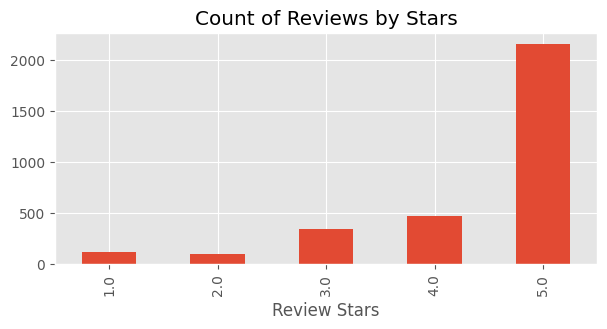

In [41]:
ax = df['overall'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(7, 3))
ax.set_xlabel('Review Stars')
plt.show()

#Step 1. VADER Seniment Scoring¶
We will use NLTK's SentimentIntensityAnalyzer to get the neg/neu/pos scores of the text.

This uses a "bag of words" approach:

1-Stop words are removed

2-each word is scored and combined to a total score

In [46]:
import nltk
nltk.download('vader_lexicon') #removed extra space
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [47]:
sia.polarity_scores('I am so happy!')


{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [67]:
example = sia.polarity_scores('This is the worst thing ever.')
print(example)


{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}


In [ ]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['reviewText']
    myid = row['reviewerID']

    # Check if text is a string before processing
    if isinstance(text, str):
        res[myid] = sia.polarity_scores(text)
    else:
        print(f"Skipping row {i} due to invalid text type: {type(text)}")
        # Add this line to print the problematic rows

In [56]:
res

{'ALJ66O1Y6SLHA': {'neg': 0.0, 'neu': 0.406, 'pos': 0.594, 'compound': 0.6588},
 'A3W11493KS6Z2L': {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 'A3HX4X3TIABWOV': {'neg': 0.0,
  'neu': 0.709,
  'pos': 0.291,
  'compound': 0.8829},
 'AW8UBYMNJ894V': {'neg': 0.068, 'neu': 0.632, 'pos': 0.3, 'compound': 0.8777},
 'A265UZVOZWTTXQ': {'neg': 0.0,
  'neu': 0.669,
  'pos': 0.331,
  'compound': 0.7845},
 'A3QY3THQ42WSCQ': {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 'AGZ5OOZVDO194': {'neg': 0.0, 'neu': 0.278, 'pos': 0.722, 'compound': 0.8313},
 'A3GJ3DJU1RXOHN': {'neg': 0.0,
  'neu': 0.895,
  'pos': 0.105,
  'compound': 0.6249},
 'A232J1FHOQI5YN': {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.8555},
 'A2ON4RYI9Z4SQ': {'neg': 0.039,
  'neu': 0.857,
  'pos': 0.104,
  'compound': 0.6985},
 'A1EZN3E9R322YJ': {'neg': 0.288,
  'neu': 0.712,
  'pos': 0.0,
  'compound': -0.6642},
 'A3T8NHQYBQSV1X': {'neg': 0.196,
  'neu': 0.804,
  'pos': 0.0,
  'compound': -0.296},
 'A2NEJIX5N

In [57]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'reviewerID'})
vaders = vaders.merge(df, how='left')

In [60]:
vaders.sample(5)

,reviewerID,neg,neu,pos,compound,overall,verified,reviewTime,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
2293,A1R7S4XNZLSLBH,0.175,0.825,0.000,-0.3252,2.0,True,"12 16, 2016",B010RRWKT4,"{'Size:': ' 8 M US', 'Color:': ' Grey'}",Wollstonecraft,I returned these as they were not true to size...,Not true to size,1481846400,NaN,NaN
3129,A2077NII5H62R2,0.000,0.000,1.000,0.7574,5.0,True,"07 2, 2018",B010RRWKT4,"{'Size:': ' 8.5 M US', 'Color:': ' Green Glow/...",Amazon Customer,Perfect fit!,Five Stars,1530489600,NaN,NaN
156,A1Z8U8IPBLBEU5,0.000,0.769,0.231,0.2732,3.0,True,"07 12, 2015",B0017LD0BM,{'Size:': ' 1.50'},Seth Hanson,Not pretty for fashion but great around the ho...,Three Stars,1436659200,NaN,NaN
72,A2NEJIX5NIH2ZZ,0.364,0.307,0.330,-0.3506,3.0,True,"04 13, 2017",B000YFSR4W,"{'Size:': ' Medium', 'Color:': ' Black'}",jami,They fit great. But they fade bad,Three Stars,1492041600,NaN,NaN
2009,A2DDYH2QTGQ6FZ,0.000,0.719,0.281,0.8214,5.0,True,"02 12, 2017",B0014F7B98,"{'Size:': ' 8 B(M) US', 'Color:': ' Black/Whit...",gmathil,Good fit and comfy. Not so cushiony so define...,Good choice for training shoe,1486857600,NaN,NaN


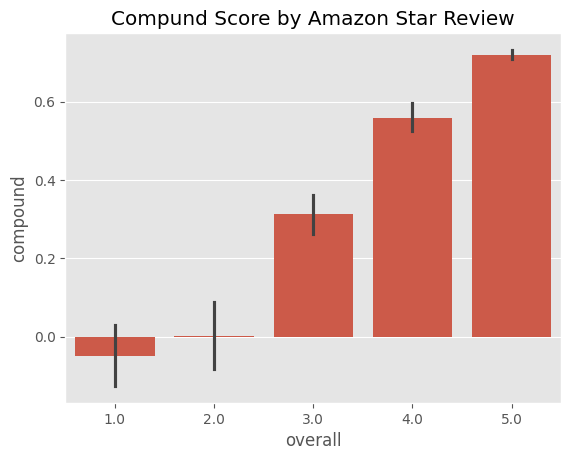

In [62]:
ax = sns.barplot(data=vaders, x='overall', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
figsize=(7, 3)
plt.show()

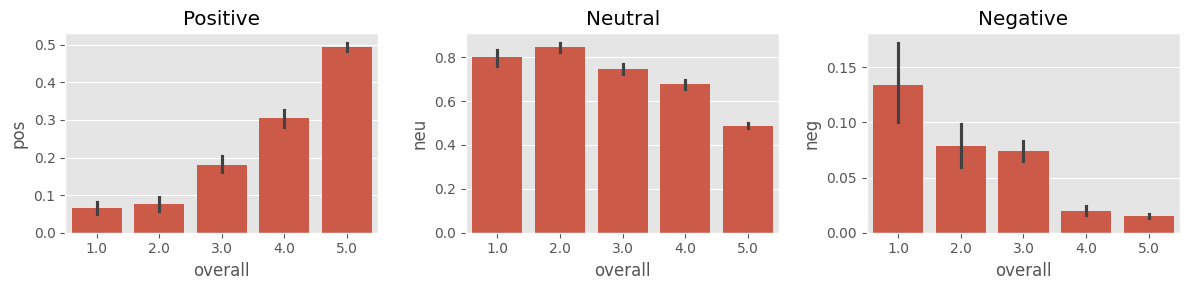

In [63]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='overall', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='overall', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='overall', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

In [64]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [65]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [68]:
#vader scores
example = sia.polarity_scores('This is the worst thing ever.')
print(example)

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}


In [70]:
# Run for Roberta Model
encoded_text = tokenizer('This is the worst thing ever.', return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.97804147, 'roberta_neu': 0.018603994, 'roberta_pos': 0.0033546288}


In [71]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [75]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['reviewText']
        # Check if the text is a string and convert to string if not.
        if not isinstance(text, str):
            text = str(text)
        myid = row['reviewerID']
        vader_result = sia.polarity_scores(text)

        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')


#---------------------------------------------------------
#res = {}
#for i, row in tqdm(df.iterrows(), total=len(df)):
  #  try:
   #     text = row['reviewText']
    #    myid = row['reviewerID']
     #   vader_result = sia.polarity_scores(text)

      #  roberta_result = polarity_scores_roberta(text)
      #  both = {**vader_result, **roberta_result}
       # res[myid] = both
    #except RuntimeError:
     #   print(f'Broke for id {myid}')

  0%|          | 0/3176 [00:00<?, ?it/s]

In [77]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'reviewerID'})
results_df = results_df.merge(df, how='left')

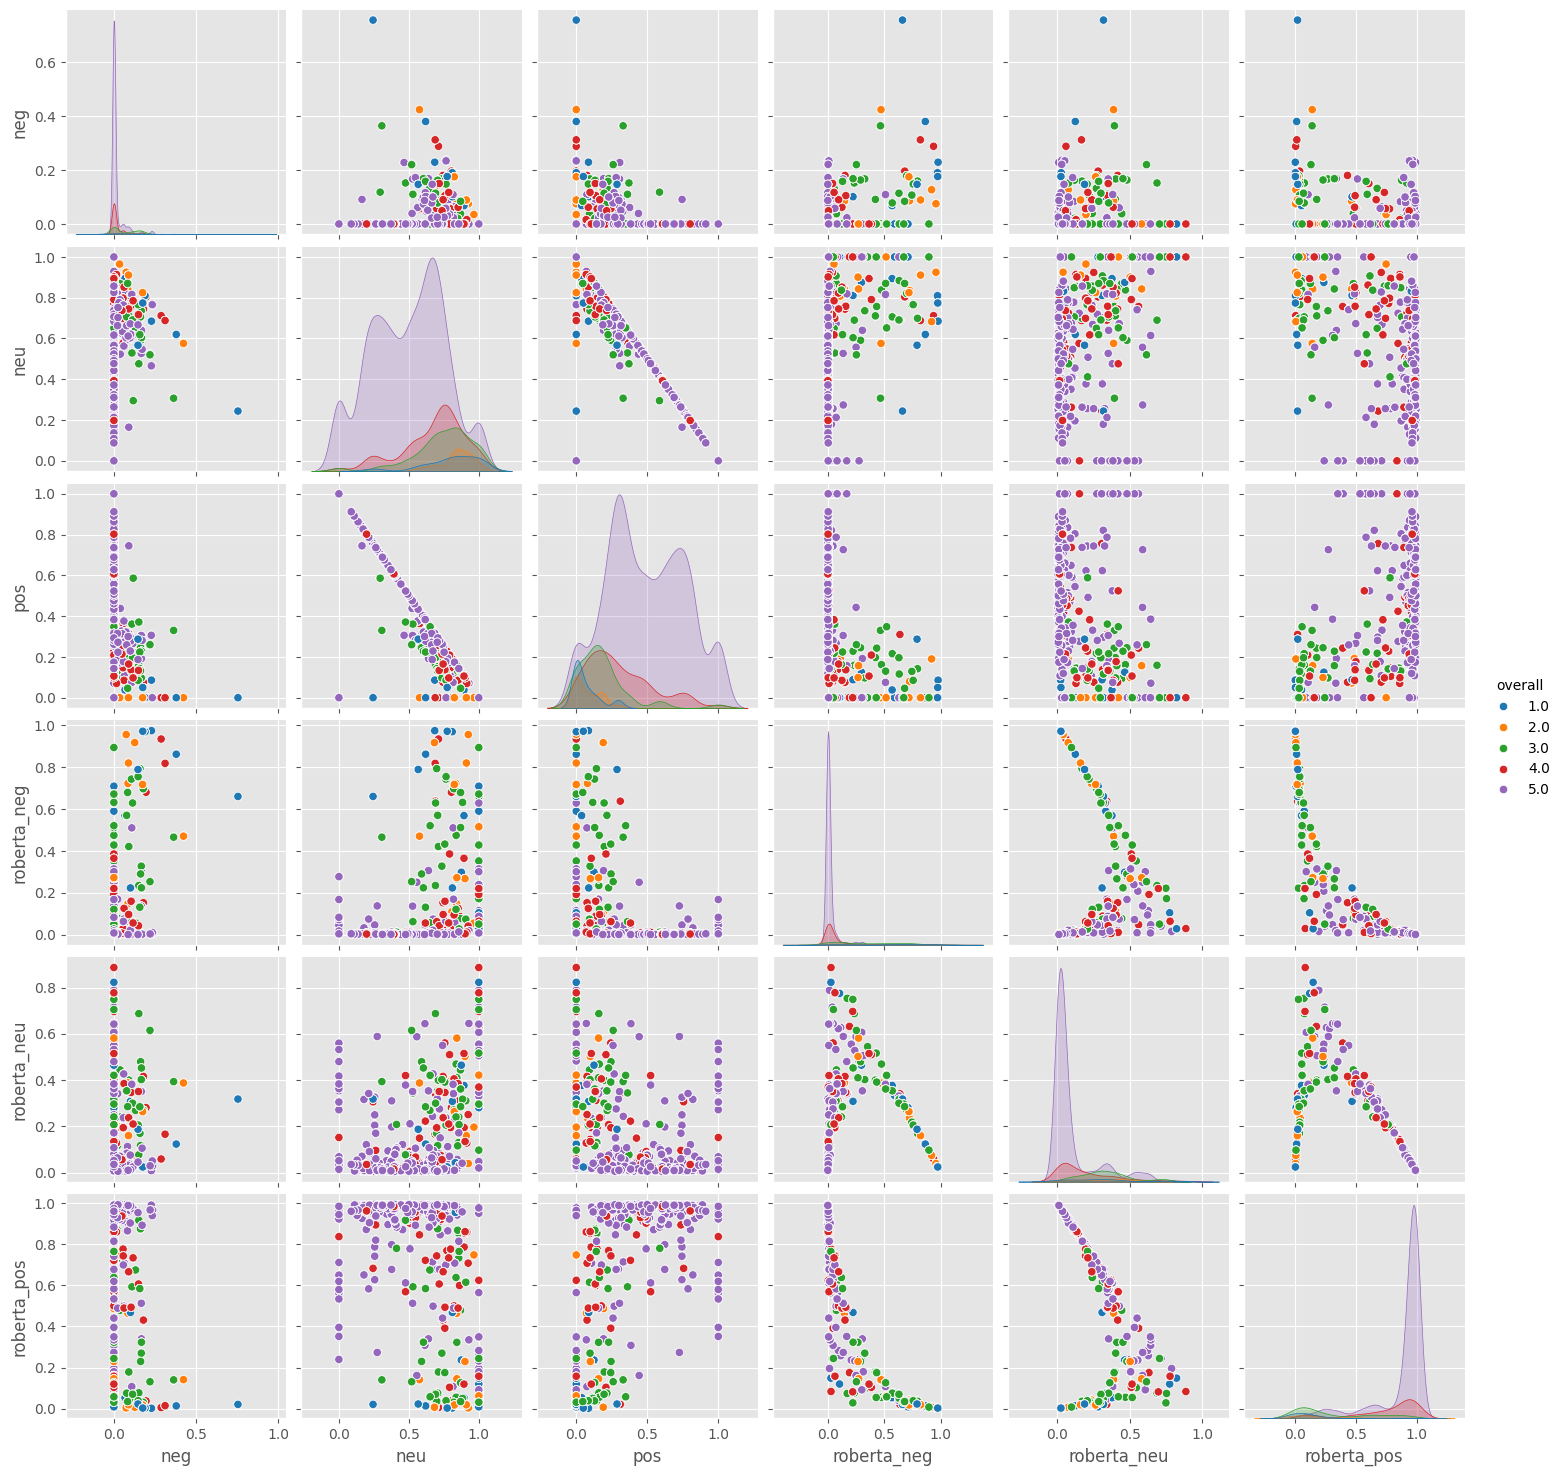

In [83]:
sns.pairplot(data=results_df,
             vars=['neg', 'neu', 'pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='overall',
            palette='tab10'
            )
plt.show()

#Extra: The Transformers Pipeline¶
Quick & easy way to run sentiment predictions

In [84]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
